In [21]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(20*5*5, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 5*5*20)
        x = self.fc(x)
        return x

In [26]:
train_X = (torch.tensor(train_X, dtype=torch.float32)/255).unsqueeze(1).to(device)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).unsqueeze(1).to(device)
train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
test_y = (torch.tensor(test_y, dtype=torch.int64)).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_24344\3907697704.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_X, dtype=torch.float32)/255).unsqueeze(1).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_24344\3907697704.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = (torch.tensor(test_X, dtype=torch.float32)/255).unsqueeze(1).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_24344\3907697704.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = (torch.

In [27]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=64, shuffle=True)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
losses = []
test_losses = []
train_losses = []
for epoch in range(10):
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            output = model(val_x)
            loss_train = criterion(output, val_y)
            output = model(test_X)
            loss_test = criterion(output, test_y)
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            test_losses.append(loss_test.item())
            train_losses.append(loss_train.item())
    #print(loss.item())

Epoch 0, step 0, train_loss 2.3433547019958496, test_loss 2.3143131732940674
Epoch 0, step 500, train_loss 0.3054021894931793, test_loss 0.29175546765327454
Epoch 1, step 0, train_loss 0.15256986021995544, test_loss 0.16762997210025787
Epoch 1, step 500, train_loss 0.12648579478263855, test_loss 0.11699923127889633
Epoch 2, step 0, train_loss 0.09401443600654602, test_loss 0.10534048080444336
Epoch 2, step 500, train_loss 0.047315482050180435, test_loss 0.09305573254823685
Epoch 3, step 0, train_loss 0.09606461971998215, test_loss 0.07953876256942749
Epoch 3, step 500, train_loss 0.04938655346632004, test_loss 0.07408822327852249
Epoch 4, step 0, train_loss 0.16736598312854767, test_loss 0.07572384178638458
Epoch 4, step 500, train_loss 0.04333855211734772, test_loss 0.06507989764213562
Epoch 5, step 0, train_loss 0.06304050236940384, test_loss 0.0665726587176323
Epoch 5, step 500, train_loss 0.03946861997246742, test_loss 0.06160179525613785
Epoch 6, step 0, train_loss 0.0165865607559

In [29]:
# Calculate test accuracy
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9851


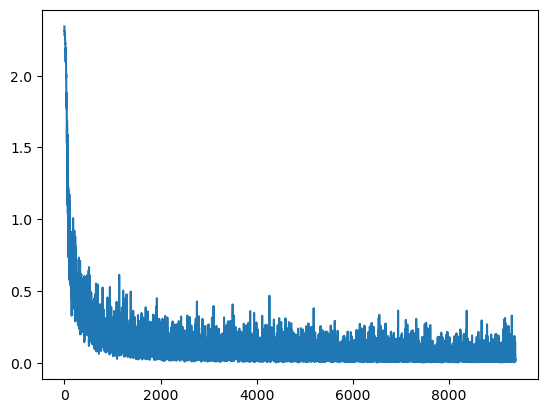

In [30]:
%matplotlib inline
plt.plot(losses)
plt.show()

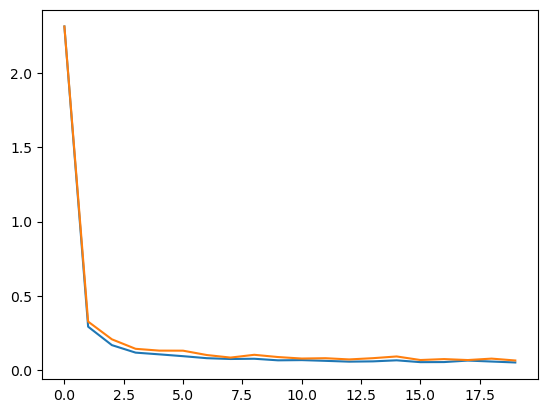

In [31]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [32]:
#hessian_comp = hessian(model, criterion, data=(train_X, train_y), cuda=False)

In [33]:
# trace = hessian_comp.trace()
# print("The trace of this model is: %.4f"%(np.mean(trace)))

In [34]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print("The top two eigenvalues of this model are: ", top_eigenvalues)

In [35]:
# t0 = time.time()
# density_eigen, density_weight = hessian_comp.density()
# print("Obtained eigendensities and eigenweights in %.2f seconds"%(time.time()-t0))
# get_esd_plot(density_eigen, density_weight)